# Network anomaly detection (Isolation forest)

https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [3]:
!pip install scikit-learn pandas matplotlib plotly

     ---------------------------------------- 0.0/162.3 kB ? eta -:--:--
     ----------------------------------- -- 153.6/162.3 kB 4.6 MB/s eta 0:00:01
     -------------------------------------- 162.3/162.3 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -- ------------------------------------- 0.6/7.6 MB 11.8 MB/s eta 0:00:01
   ------- -------------------------------- 1.4/7.6 MB 17.5 MB/s eta 0:00:01
   ------------- -------------------------- 2.6/7.6 MB 18.7 MB/s eta 0:00:01
   ---------------------- ----------------- 4.4/7.6 MB 23.4 MB/s eta 0:00:01
   ----------------------------------- ---- 6.8/7.6 MB 29.0 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 32.6 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 32.6 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 20.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.7 MB ? eta -:--:--
   ----- ---

In [30]:
!pip install kaleido

In [14]:
import numpy as np
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
kdd_df = pd.read_csv("kddcup_dataset.csv", index_col=None)

In [6]:
y = kdd_df["label"].values

트래픽 유형의 비율

In [7]:
Counter(y).most_common()

[('normal', 39247),
 ('back', 1098),
 ('apache2', 794),
 ('neptune', 93),
 ('phf', 2),
 ('portsweep', 2),
 ('saint', 1)]

normal을 제외한 모든 레이블들을 단일 anomalous 클래스로 통일시킴

In [8]:
def label_anomalous(text):
    if text == "normal":
        return 0 # normal
    else:
        return 1 # anomalous

In [9]:
kdd_df["label"] = kdd_df["label"].apply(label_anomalous)

정상 대비 이상의 비율 계산, 성능 개선 - 오염 매개변수(contamination parameter)

In [10]:
y = kdd_df["label"].values

In [11]:
counts = Counter(y).most_common() 
contamination_parameter = counts[1][1] / (counts[0][1] + counts[1][1])

범주형을 수치형으로 변환

In [12]:
encodings_dictionary = dict()

In [15]:
for c in kdd_df.columns:
    if kdd_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        kdd_df[c] = encodings_dictionary[c].fit_transform(kdd_df[c])

dataset을 정상과 이상으로 분할

In [16]:
kdd_df_normal = kdd_df[kdd_df["label"] == 0]
kdd_df_abnormal = kdd_df[kdd_df["label"] == 1]

In [17]:
y_normal = kdd_df_normal.pop("label").values 
X_normal = kdd_df_normal.values 
y_anomaly = kdd_df_abnormal.pop("label").values 
X_anomaly = kdd_df_abnormal.values

dataset을 훈련과 테스트로 분할

In [18]:
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.3, random_state=1) 
X_anomaly_train, X_anomaly_test, y_anomaly_train, y_anomaly_test = train_test_split(X_anomaly, y_anomaly, test_size=0.3, random_state=1)

In [19]:
X_train = np.concatenate((X_normal_train, X_anomaly_train)) 
y_train = np.concatenate((y_normal_train, y_anomaly_train)) 
X_test = np.concatenate((X_normal_test, X_anomaly_test)) 
y_test = np.concatenate((y_normal_test, y_anomaly_test))

Isolation forest train

In [20]:
IF = IsolationForest(contamination=contamination_parameter) 
IF.fit(X_train, y_train)

IsolationForest(contamination=0.04825763270848995)

분류기 점수 계산

In [21]:
decisionScores_train_normal = IF.decision_function(X_normal_train) 
decisionScores_train_anomaly = IF.decision_function(X_anomaly_train)

정상적인 dataset에 대한 점수를 그래프로 표시

In [31]:
fig = go.Figure(data=[go.Histogram(x=decisionScores_train_normal)])

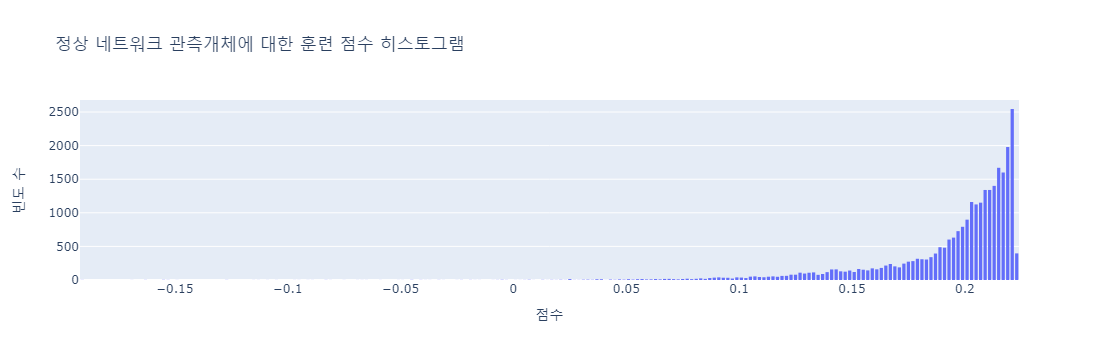

In [32]:
fig.update_layout(
    title_text='정상 네트워크 관측개체에 대한 훈련 점수 히스토그램',
    xaxis_title_text='점수',
    yaxis_title_text='빈도 수',
    bargap=0.2,
    bargroupgap=0.1
)

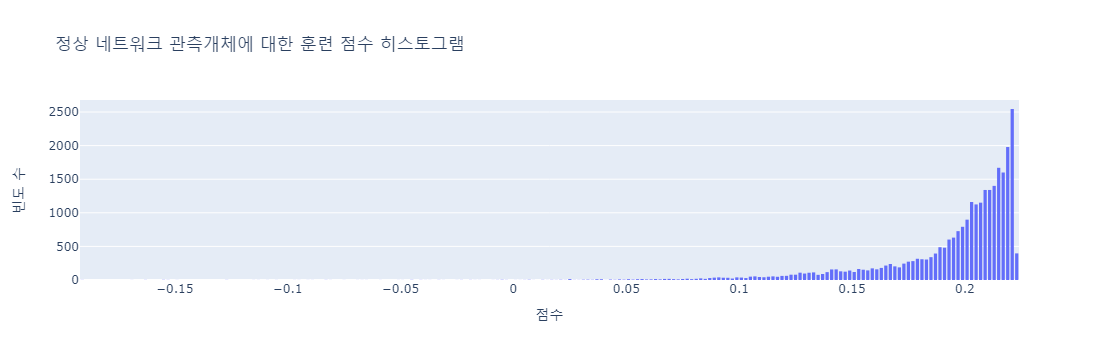

In [34]:
fig.show()

이상값 dataset에 대한 점수를 그래표로 표시

In [35]:
fig = go.Figure(data=[go.Histogram(x=decisionScores_train_anomaly)])

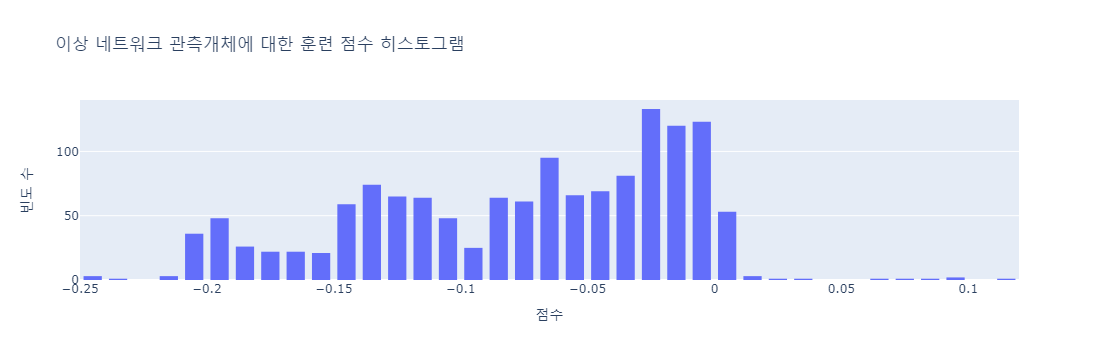

In [36]:
fig.update_layout(
    title_text='이상 네트워크에 대한 훈련 점수 히스토그램',
    xaxis_title_text='점수',
    yaxis_title_text='빈도 수',
    bargap=0.2,
    bargroupgap=0.1
)

정상(normal)과 이상(anolous) 구분을 위한 차단값(cutoff) 설정

In [39]:
cutoff = 0

차단값 조사

In [40]:
normal_in_test = Counter(y_test)[0]
anormaly_in_test = Counter(y_test)[1]

In [41]:
rmal_in_test = Counter(y_test)[0]
anormaly_in_test = Counter(y_test)[1]
print(f" 차단값을 적용 안했을 때 테스트 세트에서\t 정상 네트워크 수: {normal_in_test:6,}, 비정상 네트워크 수: {anormaly_in_test:3,}")

 차단값을 적용 안했을 때 테스트 세트에서	 정상 네트워크 수: 11,775, 비정상 네트워크 수: 597


In [42]:
normal_cutoff_in_test = Counter(y_test[cutoff > IF.decision_function(X_test)])[0]
anormaly_cutoff_in_test = Counter(y_test[cutoff > IF.decision_function(X_test)])[1]
print(f" 차단값 {cutoff}을 적용 했을 때 테스트 세트에서\t 정상 네트워크 수: {normal_cutoff_in_test:6,}, 비정상 네트워크 수: {anormaly_cutoff_in_test:3,} ")

 차단값 0을 적용 했을 때 테스트 세트에서	 정상 네트워크 수:     22, 비정상 네트워크 수: 562 
